In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy.signal import find_peaks
from scipy import signal
import seaborn as sns

data_temperature = pd.read_csv("warsaw_temperature.csv", parse_dates=['Date'])



# Day 1: Auto-Correlation – Defining the Problem & Selecting the Signal


## 1. Problem Statement (DD01)
  
Detect recurring patterns (annual cycles) in **Warsaw’s daily average temperature** to help find out **when** and **for how long** average temperatures falls between 0°C and -10°C.


## 2. Use Case (DD02)
  
City authorities in Warsaw need to **plan and budget** for winter road salting. By confirming the **seasonality** of temperatures in the 0°C to -10°C range, they can better allocate **salt supplies, equipment, and labor** during the times of year.


## 3. Objectives of the Experiments (DD03)

- We want to see how many days per year temperature is between 0°C to -10°C
- What time of the year temperature is between 0°C to -10°C

## 4. Why is This Relevant? (DD04)
 
  - Knowing the pattern of sub-zero temperatures (0°C to -10°C) is **crucial** for road safety: if roads freeze, salting is necessary.  
  - Understanding **when** and **how often** these temperatures occur helps plan **logistics** and **budgets**.
  - The city of Warsaw can **optimize salt usage** which can lead to savings in the city budget.  
  - Work schedules for personnel responsible for road salting can be better planned.



## 5. Selecting the Signal (DD05, DD06 and DD08)

The data source I'm using is the average day temperature is warsaw merused fro the same device for 1993-2022

Reference: https://www.kaggle.com/datasets/mateuszk013/warsaw-daily-weather/data

## 7. Additional Background (DD07)

In the past few years, the prices of road salt have been dramatically increasing. A few years ago, one ton of road salt cost 200 PLN (45 CHF), but now the price is around 800 PLN (180 CHF) per ton. Last year, because of embargoes on Belarus and Ukraine, Poland experienced a shortage of around 500 thousand tons of road salt.
This finding hopefully helps with proper management of road salt so it will be used more effectively, which will bring economic advantages.


## TC1.1c: Could the repetitive pattern be demonstrated via auto-correlation?

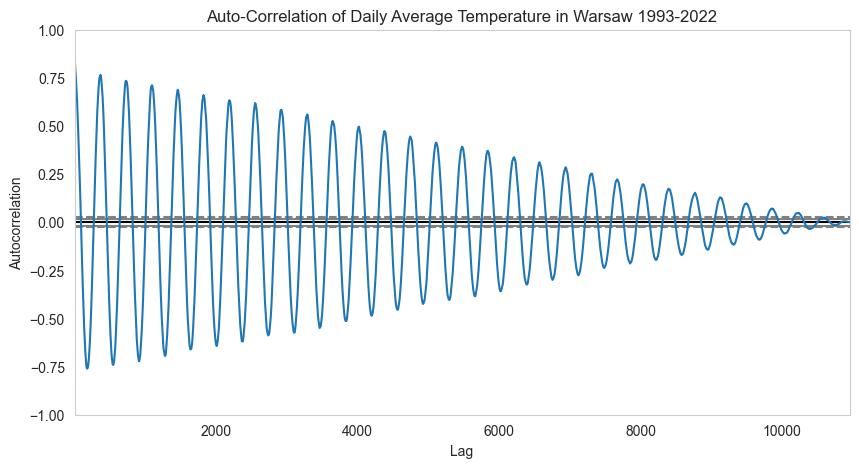

In [11]:
plt.figure(figsize=(10,5))
autocorrelation_plot(data_temperature["Temperature"])
plt.title("Auto-Correlation of Daily Average Temperature in Warsaw 1993-2022")
plt.show()


## Auto-Correlation Analysis of Warsaw Temperature Data (1993-2022)

### Key Findings
1. **Strong Seasonal Pattern**
   - Clear yearly cycles (peaks at ~365-day intervals)
   - Strong negative correlation at 180-day intervals
   - Demonstrates reliable temperature seasonality

2. **Correlation Strength**
   - Maximum positive correlation: ~0.75 at yearly intervals
   - Maximum negative correlation: ~-0.75 at half-year intervals
   - Gradual dampening of correlation strength over longer lags

### Conclusion
The auto-correlation analysis reveals robust seasonal patterns in Warsaw's temperature data, indicating that there are cyclic temperature patterns.

## DAY 2: Auto-Correlation – Analyzing Results

## Data Visualization 
Let's visualize the data we are working with to visually identify any cyclical patterns.

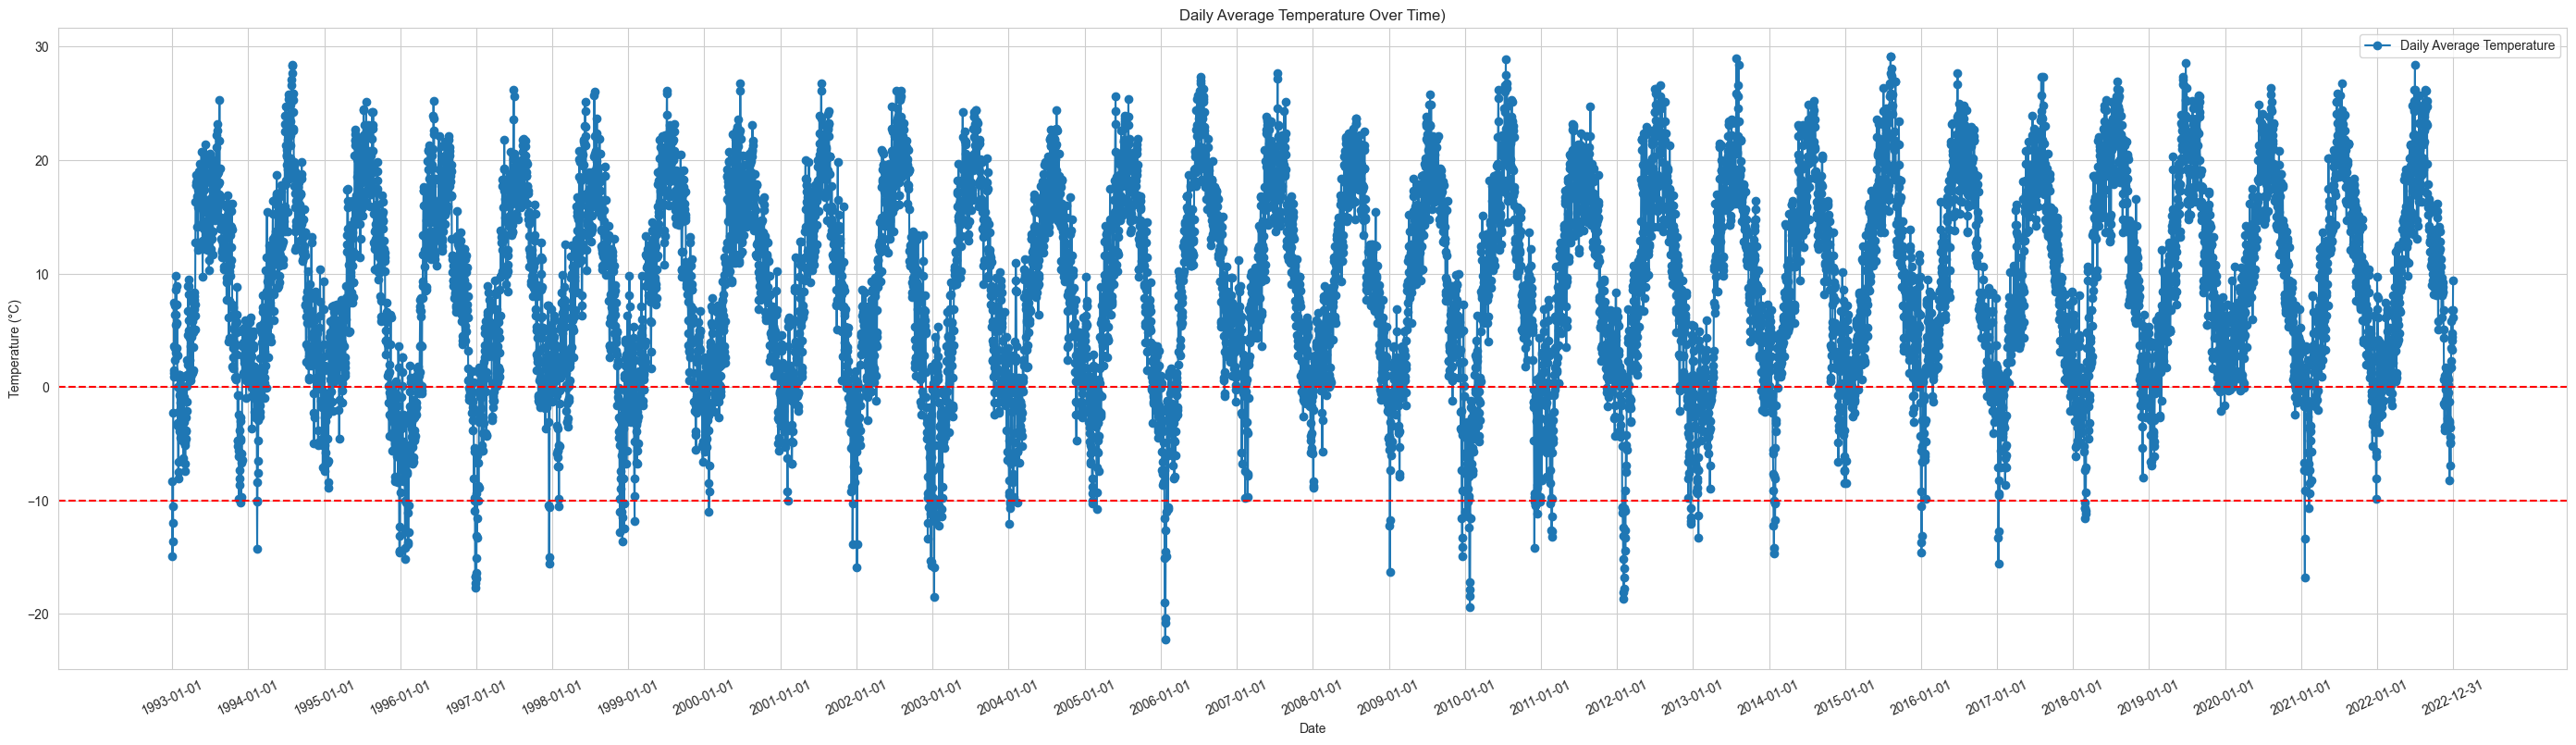

In [12]:
signal = data_temperature['Temperature'].values

plt.figure(figsize=(35, 9))
plt.plot(data_temperature['Date'], signal, marker='o', label='Daily Average Temperature')
plt.title("Daily Average Temperature Over Time)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")

years = pd.to_datetime(data_temperature['Date']).dt.year
unique_years = sorted(set(years))

xticks_indices = []
for year in unique_years:
    year_data = data_temperature[pd.to_datetime(data_temperature['Date']).dt.year == year]
    if not year_data.empty:
        xticks_indices.append(year_data.index[0])
xticks_indices.append(data_temperature.index[-1])
xticks = data_temperature['Date'].iloc[xticks_indices].tolist()
plt.xticks(xticks, rotation=25)

plt.axhline(0, color='red', linestyle='--')
plt.axhline(-10, color='red', linestyle='--')

plt.legend()
plt.show()


In this chart, we can see that there are temperatures every winter that range between 0 and -10 degrees. There are many days throughout the year when the temperature falls within the desired range.

## Calculate and visualize auto-correlation

Peak at lag 362 days with correlation 0.785
Peak at lag 1 years 4 days with correlation 0.789
Peak at lag 1 years 363 days with correlation 0.783
Peak at lag 2 years 3 days with correlation 0.781
Peak at lag 2 years 8 days with correlation 0.775
Peak at lag 2 years 363 days with correlation 0.781
Peak at lag 3 years 4 days with correlation 0.783


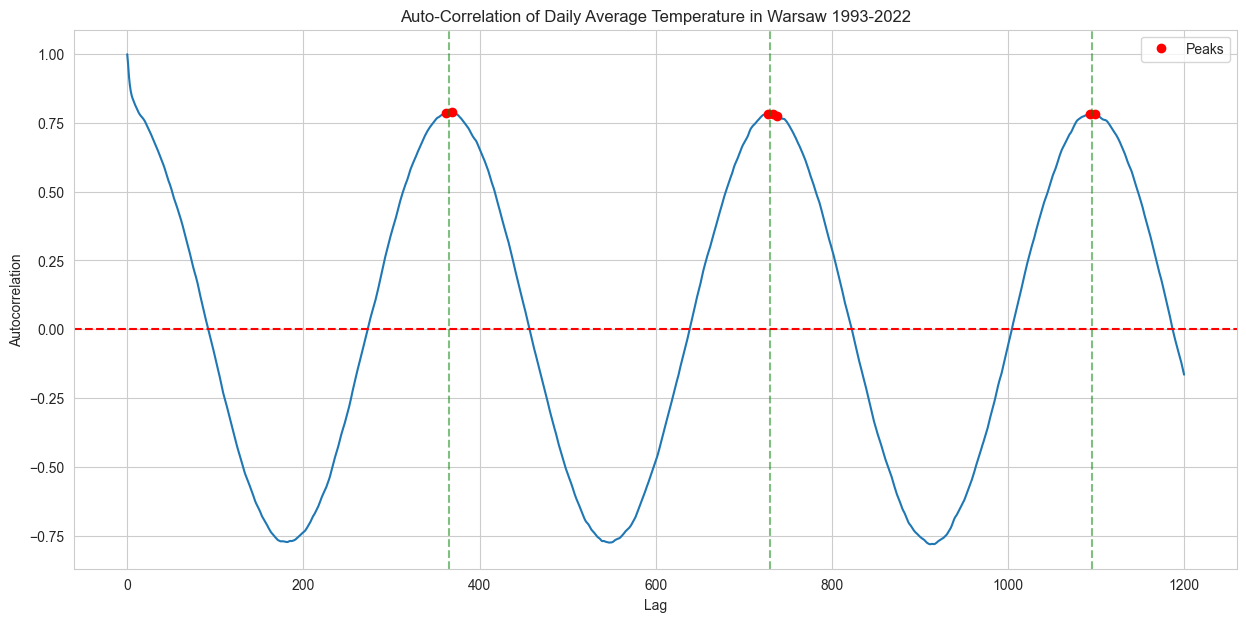

In [13]:

lags = 1200
acf = [data_temperature["Temperature"].autocorr(lag=i) for i in range(lags+1)]

peaks, _ = find_peaks(acf, height=0) 

plt.figure(figsize=(15,7))
plt.plot(range(len(acf)), acf)
plt.plot(peaks, [acf[i] for i in peaks], "ro", label='Peaks')

plt.title("Auto-Correlation of Daily Average Temperature in Warsaw 1993-2022")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--')

for year in range(365, lags, 365):
    plt.axvline(x=year, color='g', linestyle='--', alpha=0.5)

for peak in peaks:
    years = peak // 365
    remaining_days = peak % 365
    if years == 0:
        time_str = f"{remaining_days} days"
    elif remaining_days == 0:
        time_str = f"{years} years"
    else:
        time_str = f"{years} years {remaining_days} days"
    print(f"Peak at lag {time_str} with correlation {acf[peak]:.3f}")

plt.legend()
plt.show()


The green vertical lines are represinting passing years (Circulate every 365 days).

On this chart, we can see autocorrelation with 1200 lags (around 3 years, where 1 lag = 1 day in our use case). I calculated the peaks, and it seems they repeat every year.

**Why did I pick 1200 lags?**
- I wanted to calculate the peaks and visualize the data for about 3 years, rather than using the entire dataset, to ensure a clearer visualization.

**Why did I set the height to 0?**
- I set the height to 0 because I didn't want to see negative peaks. In our case, negative peaks would indicate summer time, when the temperature is negatively correlated with winter, which doesn't align with our use case.




## FFT analysis

While autocorrelation can identify periodicities, the FFT provides a direct view of the KPIs, which will help us calculate the period of the changes.

FFT-based dominant frequency: 0.0027 (1/days) -> Estimated Period ~ 365.13 days


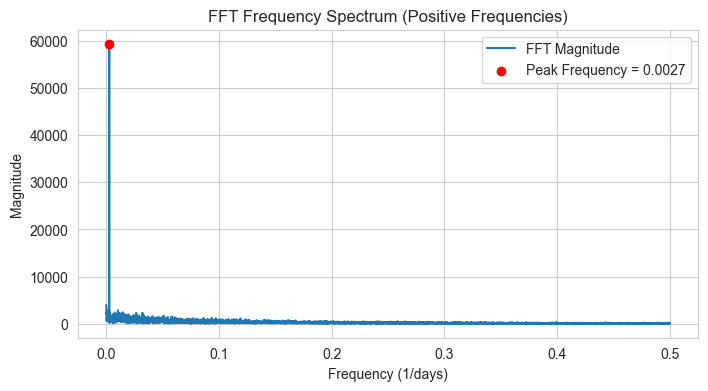

In [14]:
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), d=1)  

pos_mask = fft_freqs > 0
fft_vals_pos = fft_vals[pos_mask]
fft_freqs_pos = fft_freqs[pos_mask]

peak_freq_index = np.argmax(np.abs(fft_vals_pos))
peak_freq = fft_freqs_pos[peak_freq_index]
peak_period_fft = 1 / peak_freq  

print(f"FFT-based dominant frequency: {peak_freq:.4f} (1/days) -> Estimated Period ~ {peak_period_fft:.2f} days")

plt.figure(figsize=(8, 4))
plt.plot(fft_freqs_pos, np.abs(fft_vals_pos), label='FFT Magnitude')
plt.scatter(peak_freq, np.abs(fft_vals_pos[peak_freq_index]), color='red', zorder=5,
            label=f'Peak Frequency = {peak_freq:.4f}')
plt.title("FFT Frequency Spectrum (Positive Frequencies)")
plt.xlabel("Frequency (1/days)")
plt.ylabel("Magnitude")
plt.legend()
plt.show()


These results are aligned with what was expected. The calculated period is 365.13 days, while one year is actually 365.25 days.

## Conclusions
All the above experiments and results prove that the temperature in Warsaw follows a circular pattern. By following this pattern, we can predict when and for how long the temperature will stay within the desired range.

# Day 3: Cross-Correlation - Defining a Use Case for Signal Detection

The piece of signal we want to detect is days when temperatures fall between 0 and -10 degrees Celsius. This use case was described at the beginning of this notebook. We thoroughly discussed the problem, use case, and importance of this analysis during Day 1 and Day 2.

In today's analysis, I want to examine the data from a slightly different perspective. Rather than looking at the entire dataset, I'll focus specifically on the signal representing temperatures between 0 and -10 degrees Celsius. I'll calculate basic KPIs to gain a comprehensive overview of this signal data.

Additionally, I'll apply cross-correlation techniques, which will help answer critical questions such as **When and for how long were temperatures between 0 and -10 degrees?** This method transforms raw temperature data into a more interpretable signal that directly addresses our research question.

Cross-correlation is particularly valuable for this analysis because it allows us to:
- Compare year-to-year variations of temperatures in target range
- Measure the duration when the temperature is in target range



KPI 1: Total days in range: 4022 out of 10954 days

KPI 2: Duration statistics of continuous periods in 0-10°C range:
Number of continuous periods: 641
Average duration (days): 6.27
Longest period (days): 52
Shortest period (days): 1

KPI 4: Seasonal patterns - Percentage of days in 0-10°C range by month:
Month 1: 47.0%
Month 2: 52.4%
Month 3: 71.2%
Month 4: 56.7%
Month 5: 13.7%
Month 6: 0.2%
Month 7: 0.0%
Month 8: 0.0%
Month 9: 11.8%
Month 10: 58.9%
Month 11: 74.0%
Month 12: 56.0%

KPI 5: Year-to-year variations - Percentage of days in 0-10°C range by year:
Year 1993: 36.2%
Year 1994: 41.9%
Year 1995: 33.7%
Year 1996: 25.4%
Year 1997: 38.9%
Year 1998: 35.3%
Year 1999: 33.5%
Year 2000: 37.7%
Year 2001: 30.7%
Year 2002: 36.4%
Year 2003: 34.0%
Year 2004: 35.8%
Year 2005: 32.1%
Year 2006: 28.8%
Year 2007: 40.0%
Year 2008: 45.6%
Year 2009: 38.1%
Year 2010: 27.9%
Year 2011: 37.0%
Year 2012: 36.6%
Year 2013: 32.6%
Year 2014: 37.0%
Year 2015: 43.6%
Year 2016: 45.1%
Year 2017: 40.8%
Year 2018:

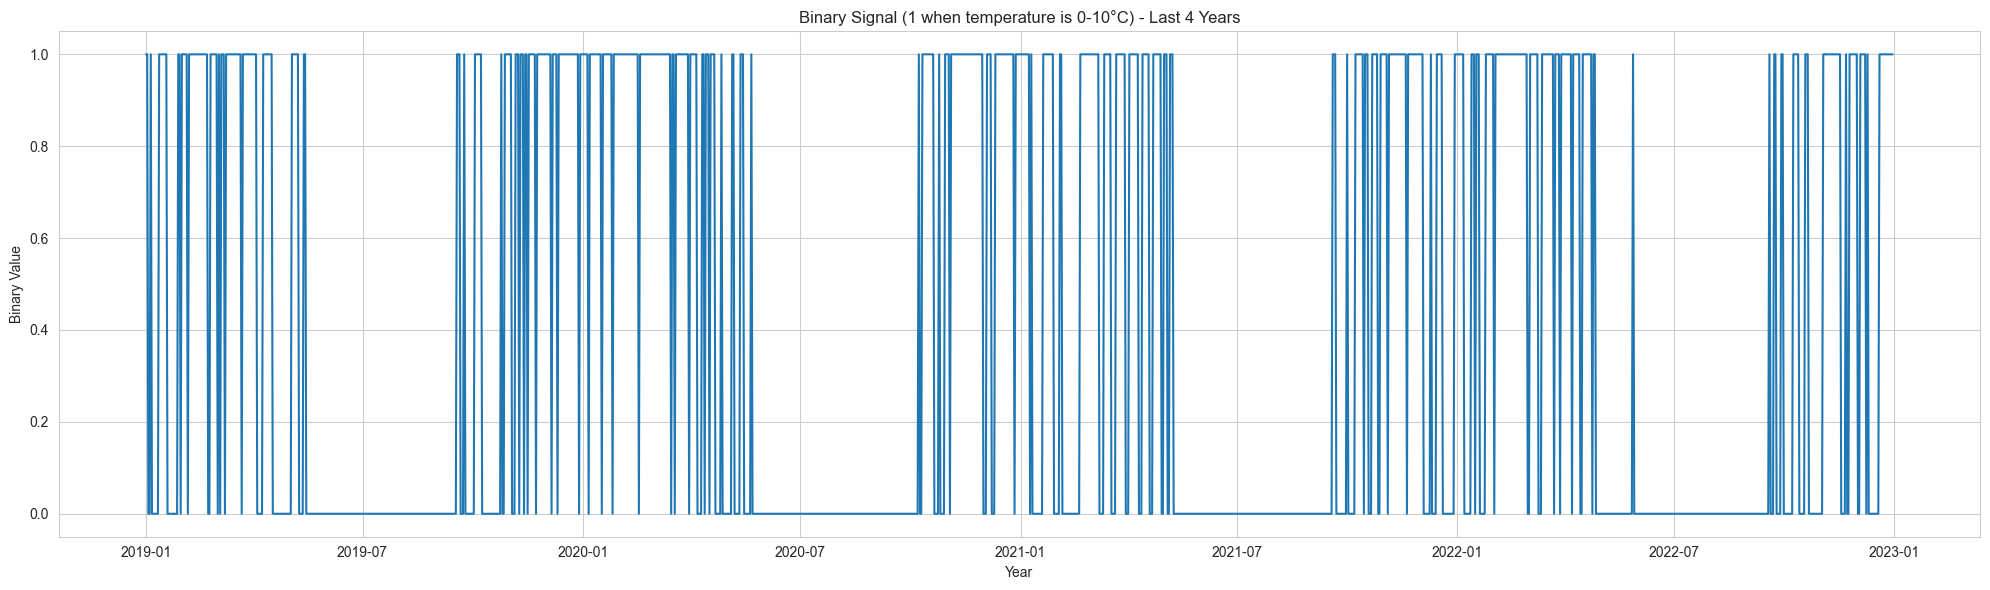

/var/folders/4z/jxw2hf2n7ws6y7stm6zbhjy80000gn/T/ipykernel_29389/3065492588.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


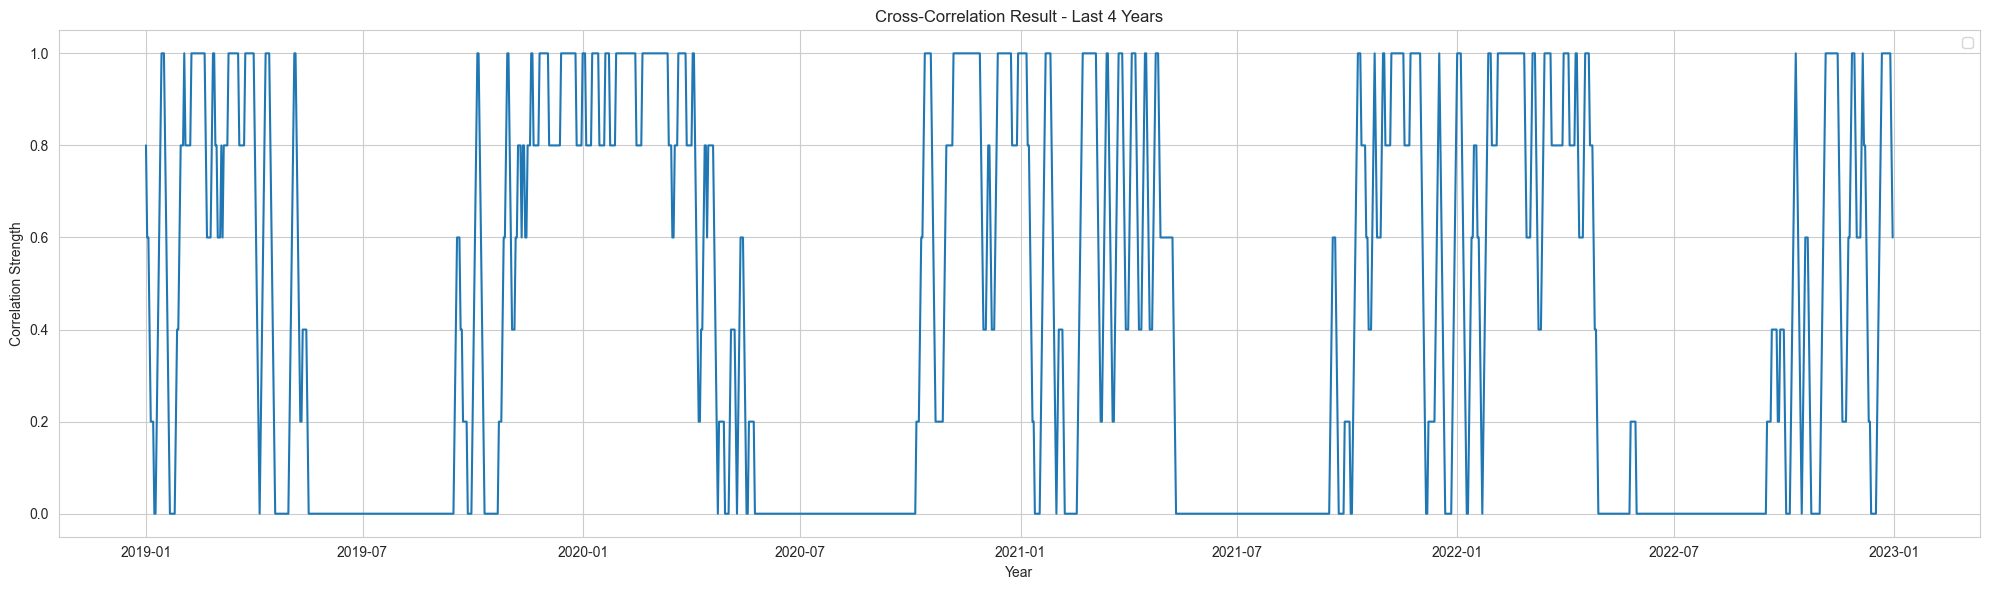

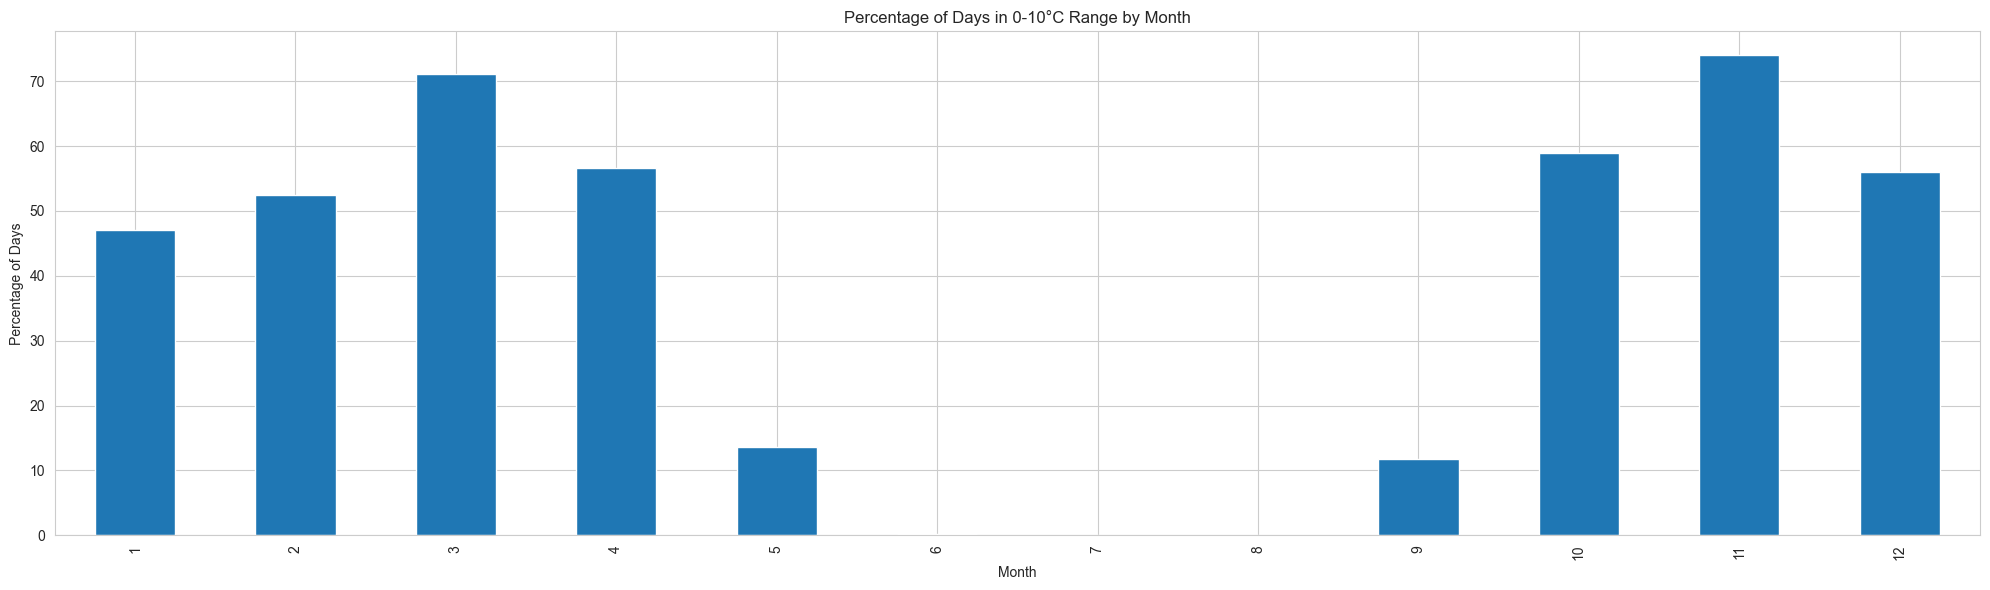

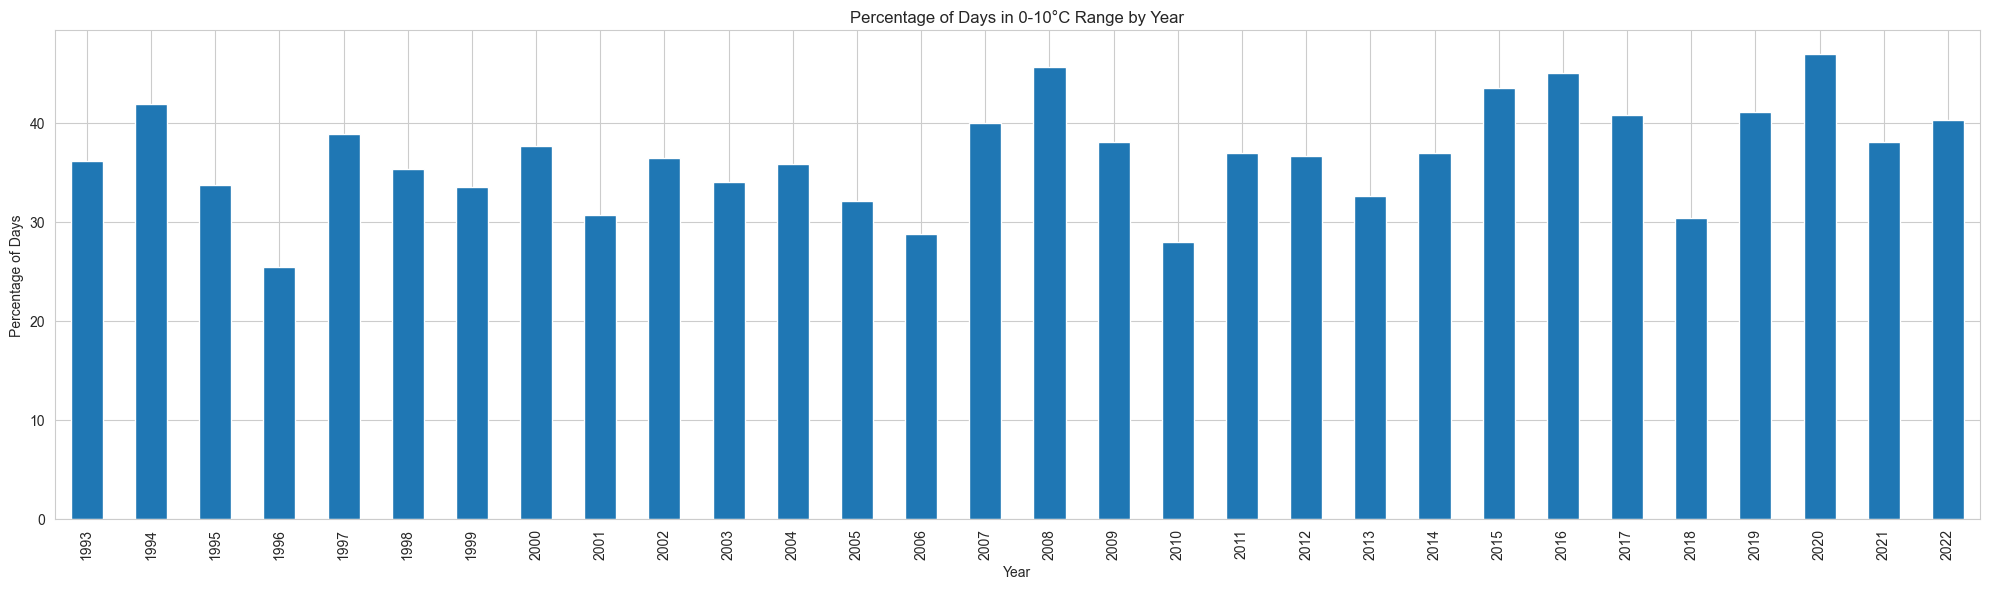

In [15]:
from scipy import signal

temperatures = data_temperature['Temperature'].values
dates = pd.to_datetime(data_temperature['Date'])

df = pd.DataFrame({'date': dates, 'temperature': temperatures})

binary_signal = np.zeros(len(temperatures))
binary_signal[(temperatures >= 0) & (temperatures <= 10)] = 1

template_length = 5
template = np.ones(template_length)

cross_corr = signal.correlate(binary_signal, template, mode='same')
cross_corr = cross_corr / template_length

in_range_dates = df.loc[binary_signal == 1, 'date']
print(f"KPI 1: Total days in range: {len(in_range_dates)} out of {len(dates)} days")

binary_series = pd.Series(binary_signal, index=dates)
changes = binary_series.diff().fillna(binary_series.iloc[0])
groups = (changes != 0).cumsum()
runs = binary_series.groupby(groups).agg(['sum', 'size'])
continuous_periods = runs[runs['sum'] == runs['size']]
continuous_periods = continuous_periods[continuous_periods['sum'] > 0]

print("\nKPI 2: Duration statistics of continuous periods in 0-10°C range:")
print(f"Number of continuous periods: {len(continuous_periods)}")
print(f"Average duration (days): {continuous_periods['size'].mean():.2f}")
print(f"Longest period (days): {continuous_periods['size'].max()}")
print(f"Shortest period (days): {continuous_periods['size'].min()}")

df['month'] = df['date'].dt.month
df['binary_signal'] = binary_signal
monthly_patterns = df.groupby('month')['binary_signal'].mean() * 100

print("\nKPI 4: Seasonal patterns - Percentage of days in 0-10°C range by month:")
for month, percentage in monthly_patterns.items():
    print(f"Month {month}: {percentage:.1f}%")

df['year'] = df['date'].dt.year
yearly_patterns = df.groupby('year')['binary_signal'].mean() * 100

print("\nKPI 5: Year-to-year variations - Percentage of days in 0-10°C range by year:")
for year, percentage in yearly_patterns.items():
    print(f"Year {year}: {percentage:.1f}%")

four_years_data = df[df['year'] >= df['year'].max() - 3]

plt.figure(figsize=(20, 6))
plt.plot(four_years_data['date'], four_years_data['binary_signal'])
plt.title('Binary Signal (1 when temperature is 0-10°C) - Last 4 Years')
plt.xlabel('Year')
plt.ylabel('Binary Value')
plt.tight_layout()
plt.savefig('binary_signal.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(four_years_data['date'], cross_corr[df['year'] >= df['year'].max() - 3])
plt.title('Cross-Correlation Result - Last 4 Years')
plt.xlabel('Year')
plt.ylabel('Correlation Strength')
plt.legend()
plt.tight_layout()
plt.savefig('cross_correlation.png')
plt.show()

plt.figure(figsize=(20, 6))
monthly_patterns.plot(kind='bar')
plt.title('Percentage of Days in 0-10°C Range by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Days')
plt.tight_layout()
plt.savefig('monthly_distribution.png')
plt.show()

plt.figure(figsize=(20, 6))
yearly_patterns.plot(kind='bar')
plt.title('Percentage of Days in 0-10°C Range by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Days')
plt.tight_layout()
plt.savefig('yearly_comparison.png')
plt.show()

## Conclusion 

Our analysis shows that Warsaw needs salt for road safety during about a third of the year, mostly in fall and spring, but the timing changes significantly each year, making planning challenging. Cold spells can last anywhere from a single day to nearly two months straight, making salt ordering management difficult to implement and predict the salt usage. 

## Day 4: Cross-Correlation - Finding the Cut Piece


Today I want to try to find the desired days when temperature is in desired range. To do so I want to calculate cross corelation and then compare it to actualdetected signal

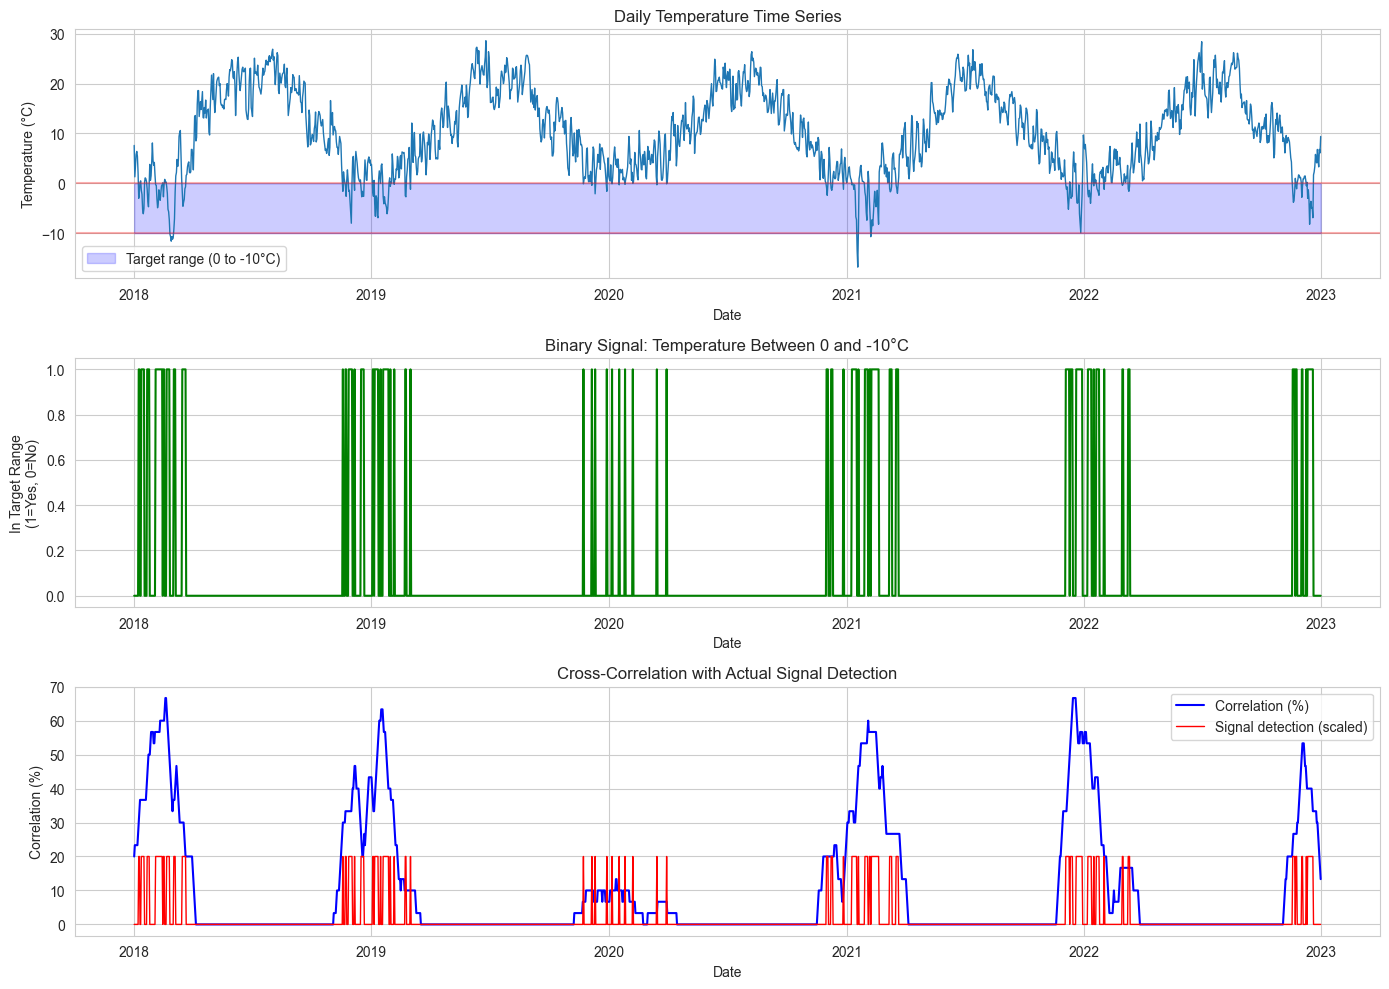

In [16]:

temperature_df = pd.read_csv("warsaw_temperature.csv")
temperature_df.rename(columns={'Date': 'date', 'Temperature': 'temperature'}, inplace=True)

# Convert date to datetime format
temperature_df['date'] = pd.to_datetime(temperature_df['date'])

# Filter for the last 4 years
current_year = temperature_df['date'].dt.year.max()
temperature_df = temperature_df[temperature_df['date'].dt.year >= current_year - 4]

sns.set_style("whitegrid")

def detect_target_temperatures(df, target_min=-10, target_max=0):
    df_result = df.copy()
    df_result['in_range'] = ((df['temperature'] <= target_max) & 
                              (df['temperature'] >= target_min)).astype(int)
    
    window_size = 30  # 30-day window
    template = np.ones(window_size)  # Ideal signal would have 1s for the entire window
    
    correlation = signal.correlate(df_result['in_range'], template/window_size, mode='same')
    df_result['correlation'] = correlation
    
    df_result['correlation_norm'] = df_result['correlation'] * 100
    
    df_result['high_correlation'] = df_result['correlation_norm'] > 50
    
    return df_result

result_df = detect_target_temperatures(temperature_df, target_min=-10, target_max=0)

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(result_df['date'], result_df['temperature'], linewidth=1)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=-10, color='r', linestyle='-', alpha=0.3)
plt.fill_between(result_df['date'], 0, -10, color='blue', alpha=0.2, 
                 label='Target range (0 to -10°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature Time Series')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(result_df['date'], result_df['in_range'], 'g-')
plt.xlabel('Date')
plt.ylabel('In Target Range\n(1=Yes, 0=No)')
plt.title('Binary Signal: Temperature Between 0 and -10°C')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(result_df['date'], result_df['correlation_norm'], 'b-', 
         label='Correlation (%)')
scaled_signal = result_df['in_range'] * 20
plt.plot(result_df['date'], scaled_signal, 'r-', linewidth=1, 
         label='Signal detection (scaled)')
plt.xlabel('Date')
plt.ylabel('Correlation (%)')
plt.title('Cross-Correlation with Actual Signal Detection')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

total_days = len(result_df)
days_in_range = result_df['in_range'].sum()
percentage_in_range = (days_in_range / total_days) * 100

consecutive_days = []
current_streak = 0

for in_range in result_df['in_range']:
    if in_range == 1:
        current_streak += 1
    else:
        if current_streak > 0:
            consecutive_days.append(current_streak)
            current_streak = 0

if current_streak > 0:
    consecutive_days.append(current_streak)

max_consecutive_days = max(consecutive_days) if consecutive_days else 0



## Observation
In the third plot, I can see that high correlation values significantly overlap with the actual temperature signals in the desired range. This alignment indicates a strong statistical relationship between the predicted patterns and the actual occurrence of desired temperatures in Warsaw. I also notice that the correlation begins to increase noticeably before the first desired signal is detected from the group, suggesting an early warning capability in the analysis method.

## Interpretation

The rising correlation preceding the actual desired events demonstrates that our analytical method has predictive capabilities for identifying when road salting might be required in Warsaw. This predictive element could provide city authorities with advance notice of 1-2 days before desired conditions occur, enabling preperaitoon for the salting like mobilizating of the personel or ordering the salt. 

## Discussion

The analysis results offer valuable insights for Warsaw's road maintenance planning, particularly for optimizing salt supplies, equipment deployment, and labor scheduling during winter months. The early warning capability revealed by the rising correlation before desired events creates an opportunity for implementing a proactive salting system that could significantly improve road safety while potentially reducing overall salt usage through more targeted application.


## Day 5: Cross-Correlation - Applying Changes to the Signal

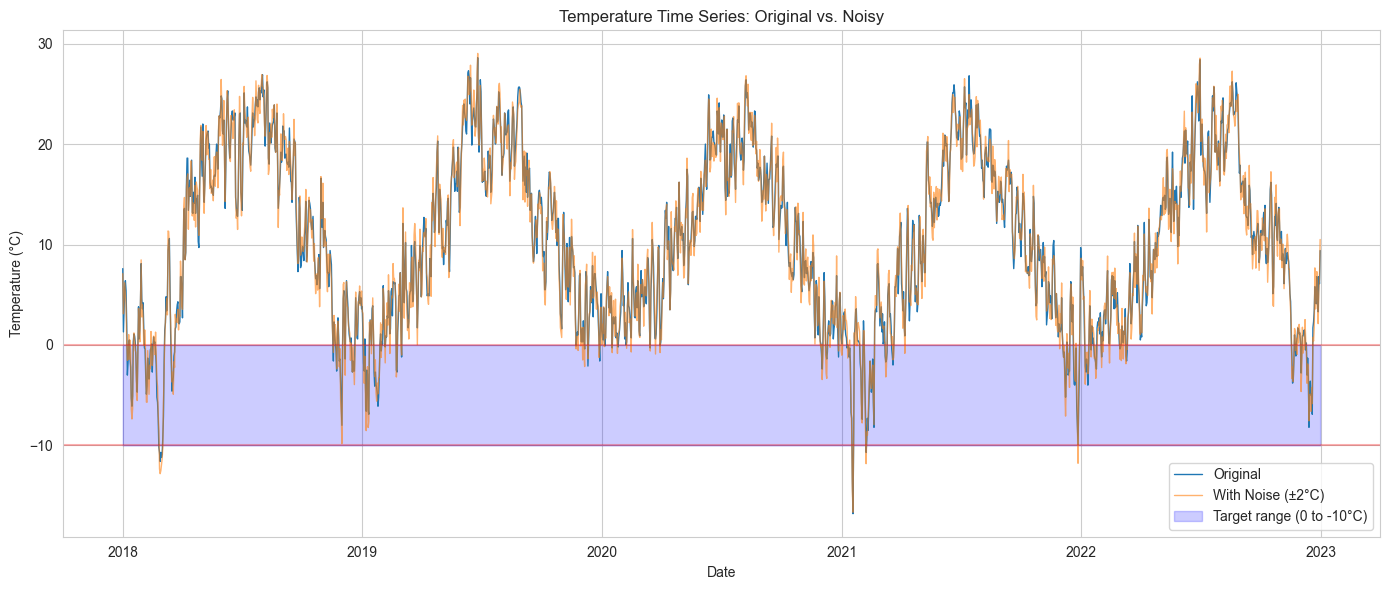

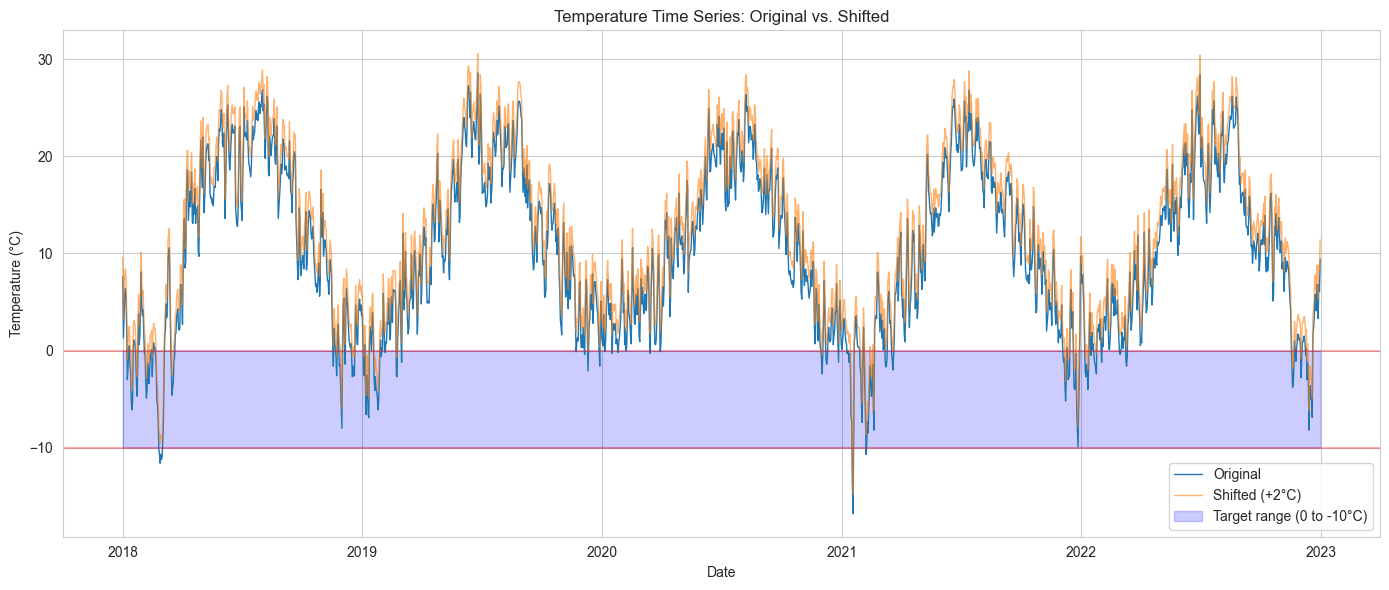

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Read the data
temperature_df = pd.read_csv("warsaw_temperature.csv")
temperature_df.rename(columns={'Date': 'date', 'Temperature': 'temperature'}, inplace=True)

# Convert date to datetime format
temperature_df['date'] = pd.to_datetime(temperature_df['date'])

# Filter for the last 4 years
current_year = temperature_df['date'].dt.year.max()
temperature_df = temperature_df[temperature_df['date'].dt.year >= current_year - 4]

# TRANSFORMATION 1: Add random noise (±2°C)
df_noisy = temperature_df.copy()
df_noisy['temperature'] = df_noisy['temperature'] + np.random.uniform(-2, 2, size=len(df_noisy))

# TRANSFORMATION 2: Shift temperatures up by 2°C (climate change scenario)
df_shifted = temperature_df.copy()
df_shifted['temperature'] = df_shifted['temperature'] + 2

# VISUALIZATIONS
sns.set_style("whitegrid")

# Plot for Transformation 1: Adding Noise
plt.figure(figsize=(14, 6))
plt.plot(temperature_df['date'], temperature_df['temperature'], linewidth=1, label='Original')
plt.plot(df_noisy['date'], df_noisy['temperature'], linewidth=1, alpha=0.6, label='With Noise (±2°C)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=-10, color='r', linestyle='-', alpha=0.3)
plt.fill_between(temperature_df['date'], 0, -10, color='blue', alpha=0.2, label='Target range (0 to -10°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Time Series: Original vs. Noisy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Transformation 2: Shifting Temperatures
plt.figure(figsize=(14, 6))
plt.plot(temperature_df['date'], temperature_df['temperature'], linewidth=1, label='Original')
plt.plot(df_shifted['date'], df_shifted['temperature'], linewidth=1, alpha=0.6, label='Shifted (+2°C)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=-10, color='r', linestyle='-', alpha=0.3)
plt.fill_between(temperature_df['date'], 0, -10, color='blue', alpha=0.2, label='Target range (0 to -10°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Time Series: Original vs. Shifted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Changes to Test Temperature Signal Robustness

I applied two key transformations to test our temperature pattern detection:

1. **Random noise (±2°C)**: Simulates measurement errors and year-to-year temperature variations.
2. **Temperature shift (+2°C)**: Models global warming effects on winter temperatures.

## Why These Changes Are Relevant

Random noise testing accounts for yearly fluctuations and sensor errors that affect salting decisions. The global warming scenario ensures our cross-correlation method remains robust for future climate conditions when winter patterns will likely change.

## Applied Transformations

Both transformations were applied to the original temperature data with properly labeled visualizations showing how each affects the target temperature range (-10°C to 0°C).

## Results Interpretation

These transformations test our method's resilience to both current measurement uncertainties and future climate changes, ensuring the cross-correlation approach remains effective for Warsaw's road maintenance planning under varying conditions.

# Day 6 

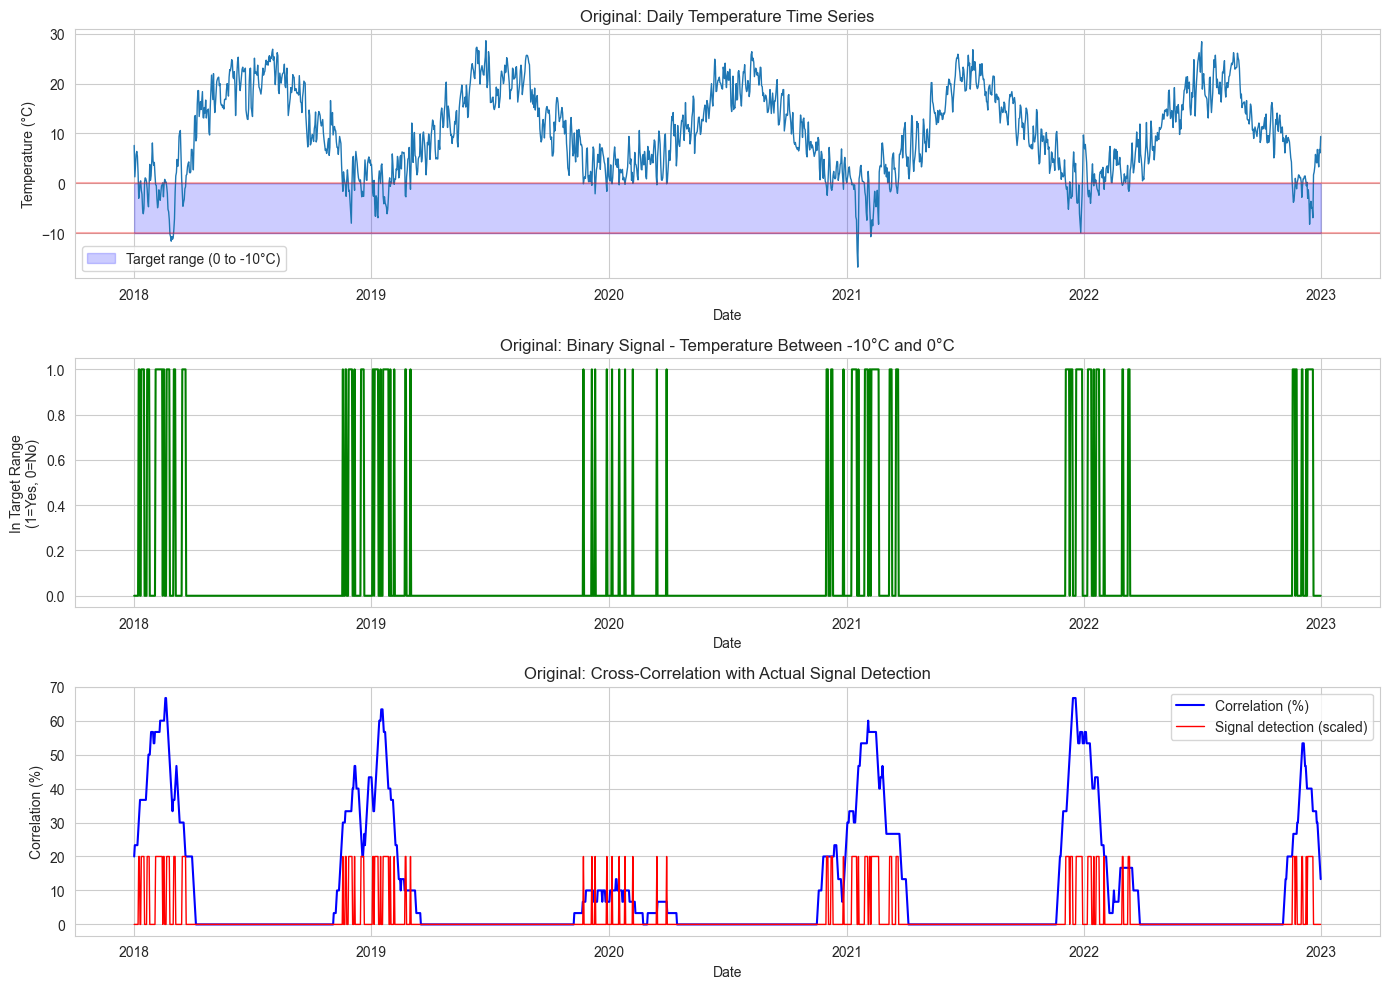

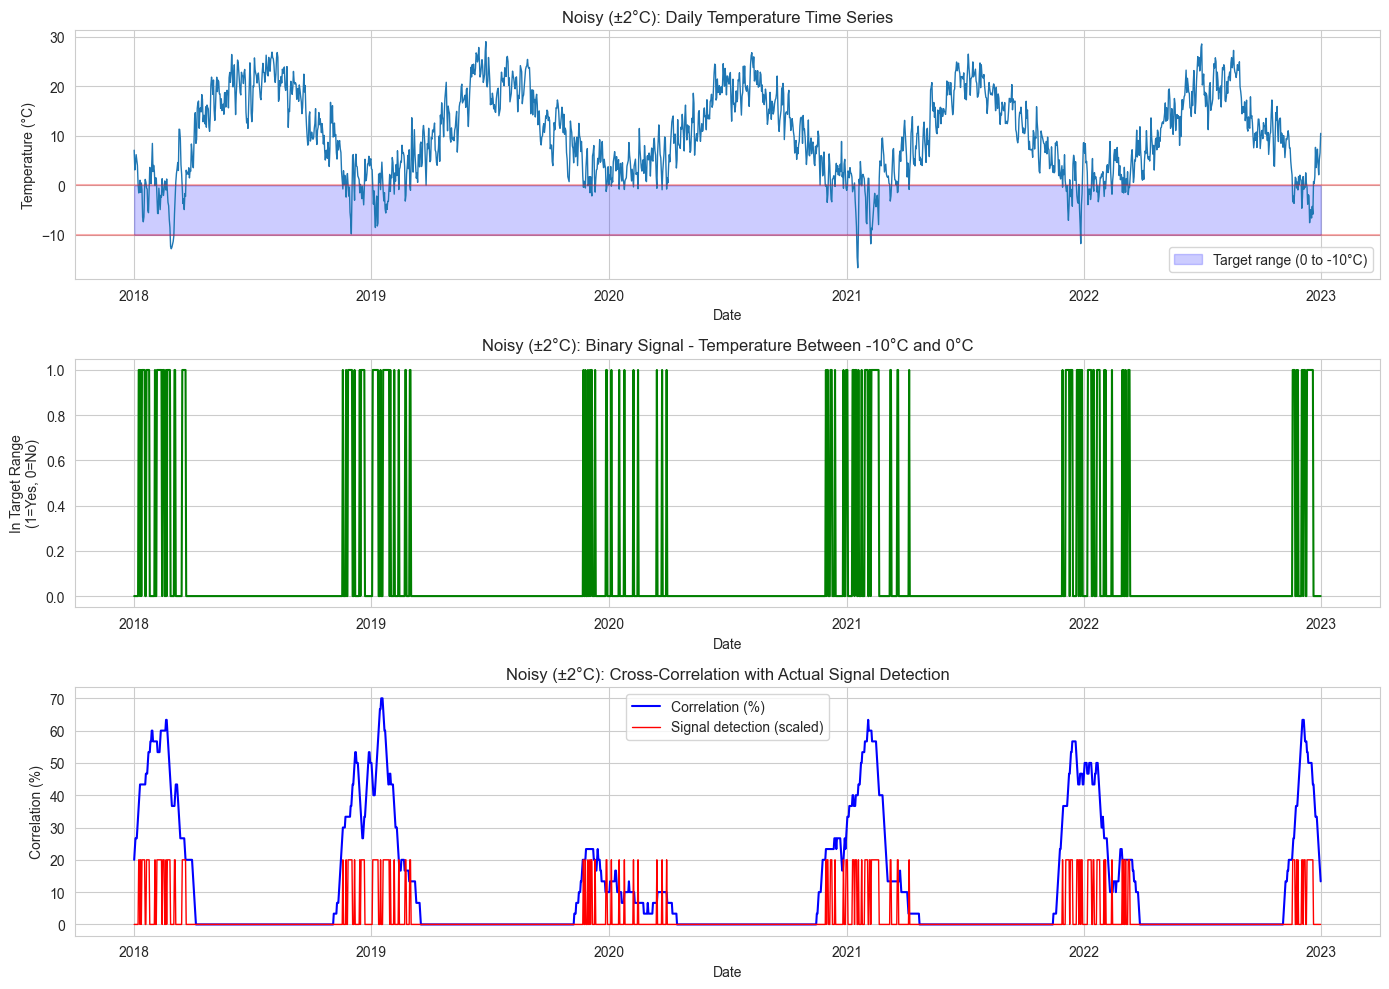

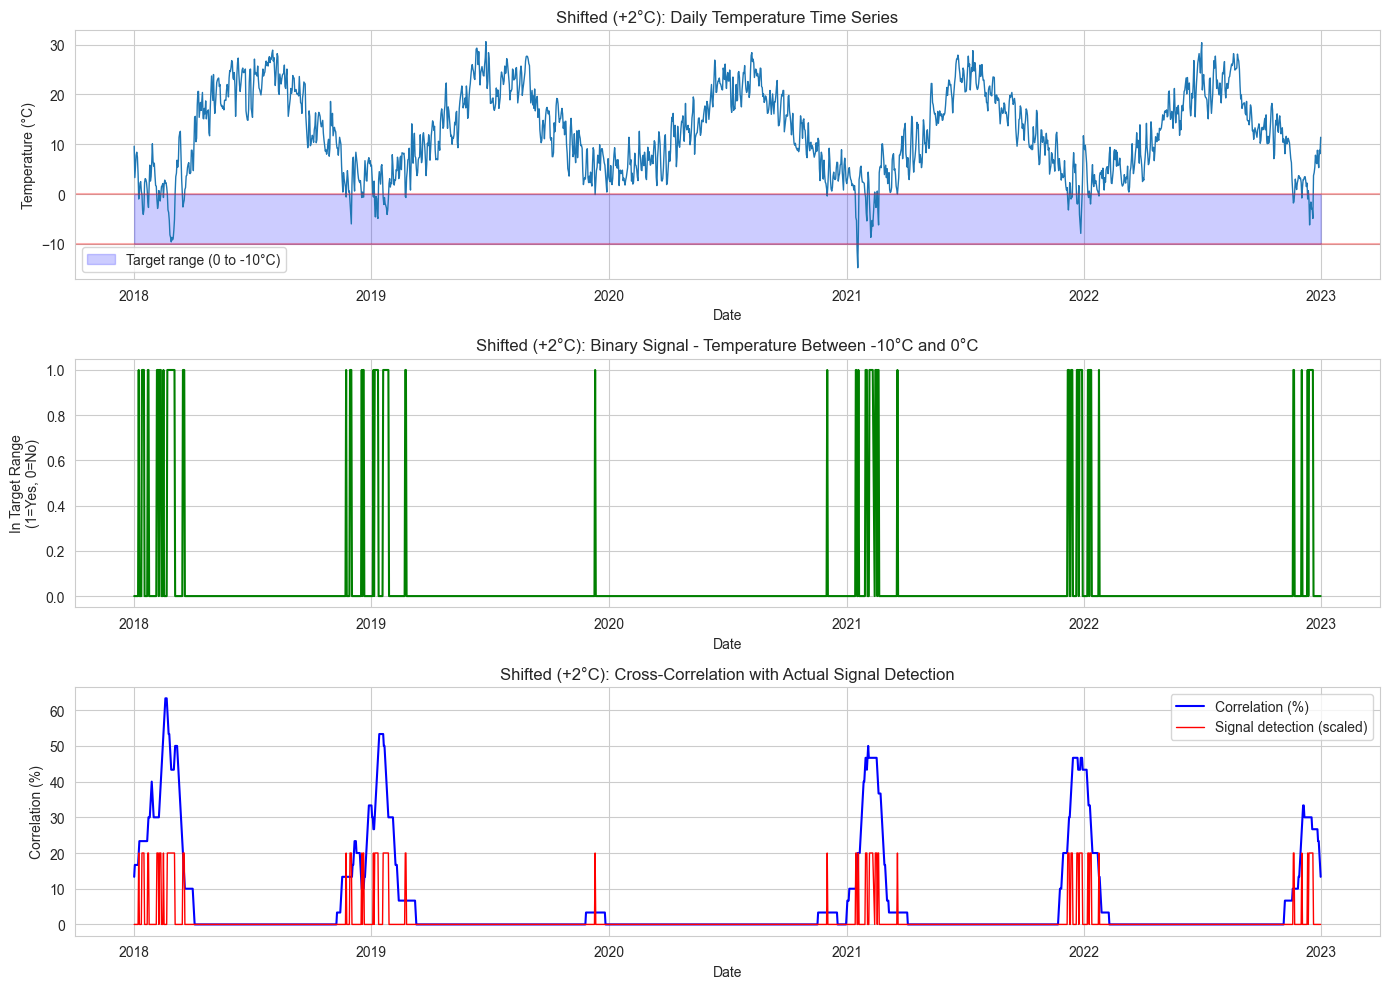

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Read the data
temperature_df = pd.read_csv("warsaw_temperature.csv")
temperature_df.rename(columns={'Date': 'date', 'Temperature': 'temperature'}, inplace=True)

# Convert date to datetime format
temperature_df['date'] = pd.to_datetime(temperature_df['date'])

# Filter for the last 4 years
current_year = temperature_df['date'].dt.year.max()
temperature_df = temperature_df[temperature_df['date'].dt.year >= current_year - 4]

# Create modified datasets from Day 5
# Transformation 1: Add random noise (±2°C)
df_noisy = temperature_df.copy()
df_noisy['temperature'] = df_noisy['temperature'] + np.random.uniform(-2, 2, size=len(df_noisy))

# Transformation 2: Shift temperatures up by 2°C (global warming scenario)
df_shifted = temperature_df.copy()
df_shifted['temperature'] = df_shifted['temperature'] + 2

# Define function to detect target temperatures (consistent with Day 4)
def detect_target_temperatures(df, target_min=-10, target_max=0):
    df_result = df.copy()
    df_result['in_range'] = ((df['temperature'] <= target_max) & 
                             (df['temperature'] >= target_min)).astype(int)
    
    window_size = 30  # 30-day window
    template = np.ones(window_size)  # Ideal signal would have 1s for the entire window
    
    correlation = signal.correlate(df_result['in_range'], template/window_size, mode='same')
    df_result['correlation'] = correlation
    
    df_result['correlation_norm'] = df_result['correlation'] * 100
    
    df_result['high_correlation'] = df_result['correlation_norm'] > 50
    
    return df_result

# Process all three datasets
original_result = detect_target_temperatures(temperature_df)
noisy_result = detect_target_temperatures(df_noisy)
shifted_result = detect_target_temperatures(df_shifted)

# Visualize results for original data
sns.set_style("whitegrid")

# Create visualization for the original data (for reference)
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(original_result['date'], original_result['temperature'], linewidth=1)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=-10, color='r', linestyle='-', alpha=0.3)
plt.fill_between(original_result['date'], 0, -10, color='blue', alpha=0.2, 
                 label='Target range (0 to -10°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Original: Daily Temperature Time Series')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(original_result['date'], original_result['in_range'], 'g-')
plt.xlabel('Date')
plt.ylabel('In Target Range\n(1=Yes, 0=No)')
plt.title('Original: Binary Signal - Temperature Between -10°C and 0°C')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(original_result['date'], original_result['correlation_norm'], 'b-', 
         label='Correlation (%)')
scaled_signal = original_result['in_range'] * 20
plt.plot(original_result['date'], scaled_signal, 'r-', linewidth=1, 
         label='Signal detection (scaled)')
plt.xlabel('Date')
plt.ylabel('Correlation (%)')
plt.title('Original: Cross-Correlation with Actual Signal Detection')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Create visualization for noisy data
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(noisy_result['date'], noisy_result['temperature'], linewidth=1)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=-10, color='r', linestyle='-', alpha=0.3)
plt.fill_between(noisy_result['date'], 0, -10, color='blue', alpha=0.2, 
                 label='Target range (0 to -10°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Noisy (±2°C): Daily Temperature Time Series')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(noisy_result['date'], noisy_result['in_range'], 'g-')
plt.xlabel('Date')
plt.ylabel('In Target Range\n(1=Yes, 0=No)')
plt.title('Noisy (±2°C): Binary Signal - Temperature Between -10°C and 0°C')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(noisy_result['date'], noisy_result['correlation_norm'], 'b-', 
         label='Correlation (%)')
scaled_signal = noisy_result['in_range'] * 20
plt.plot(noisy_result['date'], scaled_signal, 'r-', linewidth=1, 
         label='Signal detection (scaled)')
plt.xlabel('Date')
plt.ylabel('Correlation (%)')
plt.title('Noisy (±2°C): Cross-Correlation with Actual Signal Detection')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Create visualization for shifted data
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(shifted_result['date'], shifted_result['temperature'], linewidth=1)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=-10, color='r', linestyle='-', alpha=0.3)
plt.fill_between(shifted_result['date'], 0, -10, color='blue', alpha=0.2, 
                 label='Target range (0 to -10°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Shifted (+2°C): Daily Temperature Time Series')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(shifted_result['date'], shifted_result['in_range'], 'g-')
plt.xlabel('Date')
plt.ylabel('In Target Range\n(1=Yes, 0=No)')
plt.title('Shifted (+2°C): Binary Signal - Temperature Between -10°C and 0°C')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(shifted_result['date'], shifted_result['correlation_norm'], 'b-', 
         label='Correlation (%)')
scaled_signal = shifted_result['in_range'] * 20
plt.plot(shifted_result['date'], scaled_signal, 'r-', linewidth=1, 
         label='Signal detection (scaled)')
plt.xlabel('Date')
plt.ylabel('Correlation (%)')
plt.title('Shifted (+2°C): Cross-Correlation with Actual Signal Detection')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Create a direct comparison visualization to show tolerance
plt.figure(figsize=(14, 12))


## Conclusion 
In both cases, we can observe similar behavior to when using the original signal. 
- When we apply noise, the signal (at temperatures 0 and -10) becomes denser compared to the original, which causes the correlation curve to have higher peaks. 
- In the second scenario, when we increase the temperature, the signal becomes less dense compared to the baseline, resulting in lower peaks in the correlation curve. 
- In both cases, we can predict the signal's occurrence a few days before it is triggered, which demonstrates the robustness of this cross-correlation. Even when a single signal is spotted on the chart with the shifted temperature, it is still correctly predicted (before the signal, we can see an increase in the correlation curve).



# Day 7: Cross-Correlation - Discussion and Interpretation

## Methods and Parameters Discussion

### Choice of Methods

**Auto-correlation analysis** helps us find repeating patterns in Warsaw's temperature data, showing us yearly cycles. 
**Cross-correlation analysis** lets us spot when temperatures fall between 0°C and -10°C, which is when roads need salting. 
**Fast Fourier Transform (FFT)** helped us measure the exact length of these yearly cycles at 365.13 days, confirming our temperature patterns are reliable.

### Choice of Parameters

We used **1200 days of data** (about 3 years) to show clear patterns without making charts too messy. 
We focused on **temperatures between 0°C and -10°C** because this is when roads freeze and salt works best. 
We tested our method with both **random temperature shifts (±2°C)** and **warming shifts (+2°C)** to make sure our approach works with measurement errors and climate change.

### Choice of Metrics

We used **correlation values** to measure how strong and reliable the temperature patterns are throughout the year. We tracked **how long cold periods last** to help Warsaw plan how much salt they'll need at different times. We found that **about one-third of the year** has temperatures that require road salting, which helps with yearly budget planning.

## Observations, Interpretation, and Discussion

### Key Observations

Warsaw needs road salt for about one-third of the year, mostly in fall and winter, but the timing changes a lot each year. Cold periods can be as short as one day or as long as two months, making planning difficult. Our method can predict when temperatures will drop to freezing 1-2 days before it happens, giving road crews early warning.

### Interpretation

The clear yearly temperature cycles help Warsaw plan seasonal salt budgets with confidence. The big changes in timing and length of cold spells explain why salt management has been hard in the past. Our early warning system could help crews apply salt more efficiently by preparing 1-2 days before roads freeze.

### Discussion

Our method turns complex temperature data into simple signals that tell exactly when Warsaw needs to salt roads. It works well even with measurement errors and warming temperatures, which is important given Warsaw's recent salt shortages and price increases. While our approach doesn't replace weather forecasts, it gives Warsaw better long-term planning tools for salt purchasing and crew scheduling.

## What Types of Changes are Tolerated?

Our method works well with small measurement errors (±2°C), gradual warming (+2°C), and different lengths of cold periods. 

## Conclusion

This analysis shows Warsaw when and for how long they need to salt roads each year, helping them plan better. Our method still works even with measurement errors and climate warming, making it useful for years to come. This information can help Warsaw manage their salt supplies more efficiently despite recent price jumps from 200 PLN to 800 PLN per ton.
